# Question 2

This dataset provides monthly operational metrics for a major Indian airline
from 2013. It includes information on the number of departures, flight hours,
distance flown, passenger traffic, available seat kilometers, freight carried,
and mail carried. You can use any popular time series library for this task.

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from sktime.forecasting.arima import AutoARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from wheel.util import native

data = pd.read_csv('AirtrafficA4.csv')

Removing `null` values out of the data, adding a new `timestamp` column showing month + year in a specific formate.

In [85]:
data['MONTH'] = data['MONTH'].str.strip()
data['MONTH'] = data['MONTH'].replace({ 'JUNE': 'JUN', 'JULY': 'JUL' })
data['YEAR'] = data['YEAR'].astype(str)
data['MONTH'] = data['MONTH'].astype(str)
data['TIMESTAMP'] = pd.to_datetime(data['YEAR'] + '-' + data['MONTH'] + '-01', format='%Y-%b-%d')
data.fillna(0, inplace=True)
data.replace(['', ' ', 'NA', 'N/A', 'null', 'NULL'], pd.NA, inplace=True)

Making `TIMESTAMP` as the index and sorting according to it, so I can plot easily

In [86]:
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])
data.set_index('TIMESTAMP', inplace=True)
data.index = pd.DatetimeIndex(data.index.values, freq='MS')

data['PASSENGERS CARRIED'] = data['PASSENGERS CARRIED'].astype(str).str.replace(',', '').astype(float)
data.to_csv('Temp.csv')

ValueError: Inferred frequency None from passed values does not conform to passed frequency MS

Plotting a graph of passengers carried by the plan each month

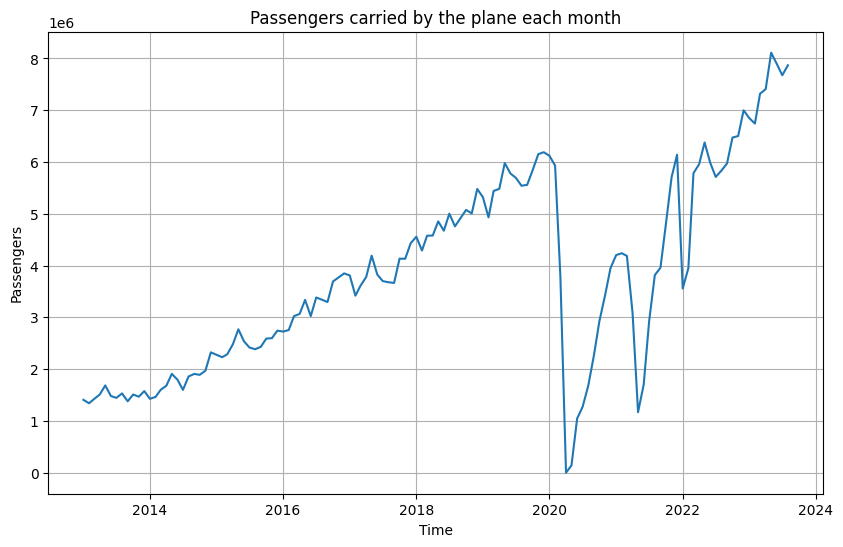

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['PASSENGERS CARRIED'])
plt.title('Passengers carried by the plane each month')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.grid(True)
plt.show()

To remove the trend, we can use differencing. Let's plot the differenced data

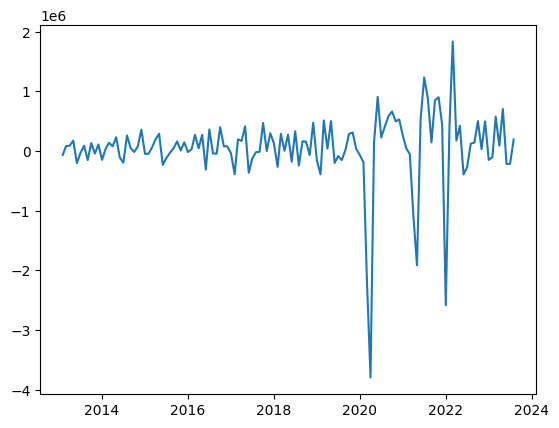

In [77]:
data['DIFF_PASSENGERS'] = data['PASSENGERS CARRIED'].diff()
data.dropna(inplace=True)
plt.plot(data.index, data['DIFF_PASSENGERS'])
plt.show()


Since the data is sorted according to `TIMESTAMP`, let's just split it into training and testing data


In [78]:

train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

train.to_csv('Train.csv')
test.to_csv('Test.csv')


Let's plot ACF, PACF for AR(p) and MA(q) models.

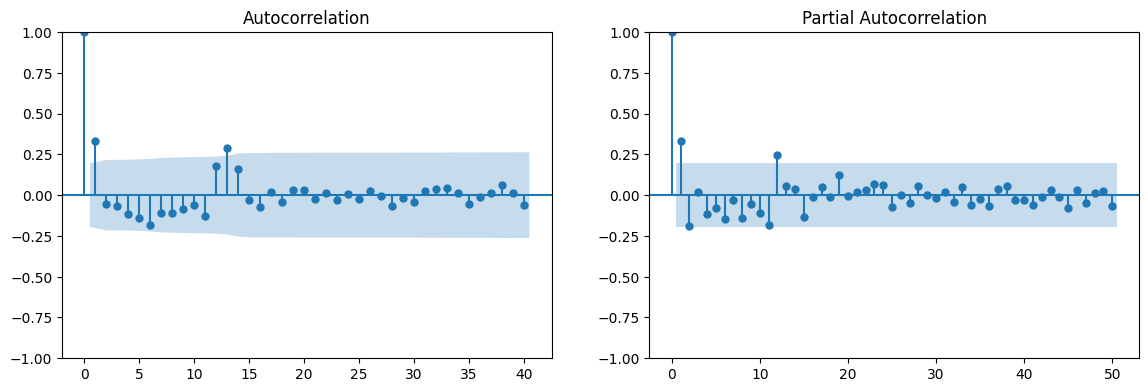

In [79]:
plt.figure(figsize=(120, 50))
plt.subplot(10, 16, 1)
plot_acf(train['DIFF_PASSENGERS'].dropna(), lags=40, ax=plt.gca())
plt.subplot(10, 16, 2)
plot_pacf(train['DIFF_PASSENGERS'].dropna(), lags=50, ax=plt.gca())
plt.show()

Since there is seasonality here, let's try an AutoARIMA model

In [80]:
model = AutoARIMA(sp=12, seasonal=True, suppress_warnings=True)
model.fit(train['DIFF_PASSENGERS'].dropna())

prediction = model.predict(fh=np.arange(len(test)))

native_forecast = train['DIFF_PASSENGERS'].shift(1).dropna()
naive_error = mean_absolute_error(test['DIFF_PASSENGERS'], native_forecast)
mase = mean_absolute_error(test['DIFF_PASSENGERS'], prediction) / naive_error
print(f'Mean Absolute Error: {mase}')

ValueError: <MonthBegin> is not supported as period frequency